# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. Для себя определим порог в 0.59. Выше - работа проведена успешно.

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
import plotly.io as pio

Отключим некритические предупреждения в коде

In [2]:
warnings.filterwarnings("ignore")

Подробнее рассмотрим **признаки**:
- `RowNumber` - индекс строки в данных
- `CustomerId` - уникальный идентификатор клиента
- `Surname` - фамилия
- `CreditScore` - кредитный рейтинг
- `Geography` - страна проживания
- `Gender` - пол
- `Age` - возраст 
- `Tenure` - сколько лет человек является клиентом банка
- `Balance` - баланс на счёте
- `NumOfProducts` - количество продуктов банка, используемых клиентом
- `HasCrCard` - наличие кредитной карты
- `IsActiveMember` - активность клиента
- `EstimatedSalary` - предпочитаемая зарплата

**Целевой признак:**
- `Exited` - факт ухода клиента

In [3]:
data = pd.read_csv('Churn.csv')

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце `Tenure` есть пустые значения, посмотрим на них.

In [6]:
data[data['Tenure'].isnull()].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Пустые значения не означает, что пользователь является клиентом банка менее одного года, поскольку значени 0 уже есть. Можно продположить, что пустые значения появились, поскольку столбец `Tenure` добавили после составления остальной таблицы. Поскольку мы не можем определить причину пустых значений, заменим их на случайные из такого же диапазона. Посмотрим гистограмму значений столбца `Tenure` до заполнения пустых значений.

<AxesSubplot:>

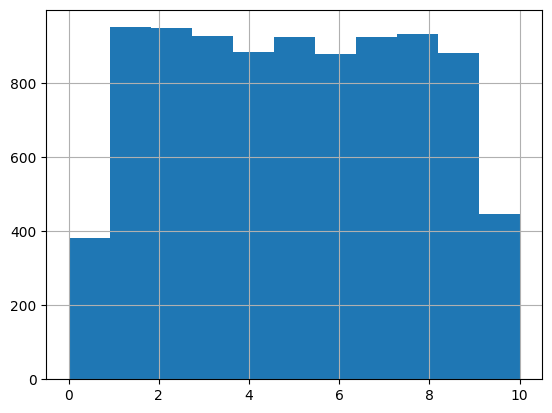

In [7]:
data['Tenure'].hist(bins=11)

In [8]:
data.loc[data['Tenure'].isnull(), 'Tenure'] = np.random.randint(0, 11, size=data[data['Tenure'].isnull()].shape[0])

Построим гистограмму значений после заполнения пустых ячеек.

<AxesSubplot:>

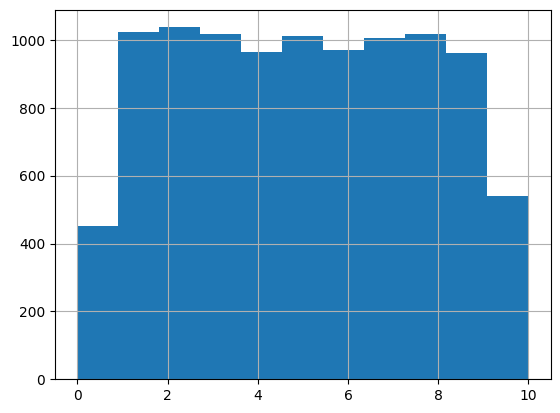

In [9]:
data['Tenure'].hist(bins=11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Количество всех значений изменились примерно равномерно, заполнение прошло успешно.

Удалим столбцы `RowNumber`, `CustomerId` и `Surname` предполагая, что они не влияют на факт ухода клиента.

In [11]:
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Применим OHE (one-hot encoding) с помощью метода `.get_dummies()`. Укажем параметр `drop_first=True`, чтобы избежать ловушку фиктивных признаков.

In [12]:
data = pd.get_dummies(data, drop_first=True)

Проверим датафрейм на наличие дубликатов.

In [13]:
print('Количество дублирующих строк в таблице:', data.duplicated().sum())

Количество дублирующих строк в таблице: 0


In [14]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Нормируем числовые данные, используя `StandardScaler()`.

In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] 

scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [16]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-1.033052,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.375939,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.024274,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.375939,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.033052,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


Посмотрим на коэффициенты корреляции. Корреляция может оказать влияние на несколько аспектов: выбор признаков, понимание взаимосвязей, предобработка данных, интерпретация результатов и др.

In [17]:
data[numeric].corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,0.006701,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.012598,0.028308,-0.030680,-0.007201
Tenure,0.006701,-0.012598,1.000000,-0.005542,0.007377,0.004286
Balance,0.006268,0.028308,-0.005542,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.007377,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.004286,0.012797,0.014204,1.000000


Для наглядность построим **HeatMap** таблицы корреляции.

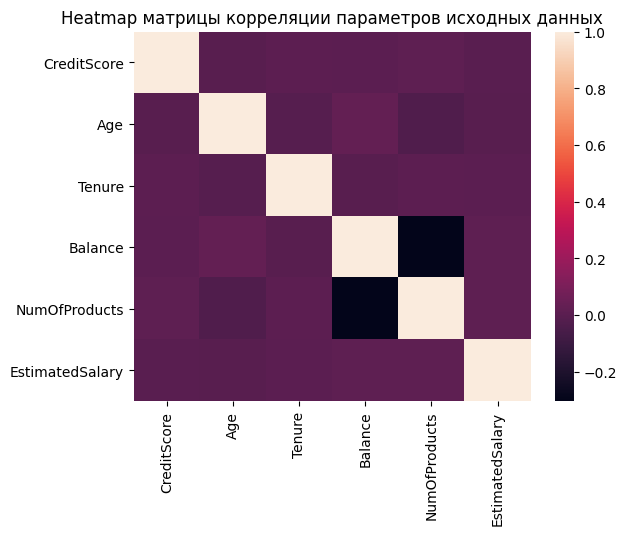

In [18]:
sns.heatmap(data[numeric].corr(),
            xticklabels=data[numeric].corr().columns,
            yticklabels=data[numeric].corr().columns)
plt.title('Heatmap матрицы корреляции параметров исходных данных')
plt.show()

Корреляции между числовыми столбцами не обнаружено. 

## Исследование задачи

Исследуем баланс классов. 

In [19]:
(data['Exited'] == 0).sum() / (data['Exited'] == 1).sum()

3.9091801669121256

Наблюдаем сильный дисбаланс классов. Клиентов, отказавшихся от услуг почти в 4 раза меньше, чем оставшихся. 

Оставим пока что данные так. Для итогового сравнения моделей с исходными и с обработанными данными.

Разделим данные на обучающую и валидационную выборки.

In [20]:
features_train, features_valid, target_train, target_valid = train_test_split(data.drop(['Exited'], axis=1),
                                                                              data['Exited'], 
                                                                              test_size=0.25,
                                                                              random_state=1337)

Сравнивать модели будем по f1-метрике.

**Дерево решений**

In [21]:
best_depth = 0
best_f1 = 0

for depth in range(1, 50):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1337)
    model.fit(features_train, target_train)
    f1 = f1_score(target_valid, model.predict(features_valid))
    best_depth, best_f1 = (depth, f1) if f1 > best_f1 else (best_depth, best_f1)

print('best depth =', best_depth, '\nbest f1 =', best_f1)

best depth = 6 
best f1 = 0.5703324808184144


In [22]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=1337)
model.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=6, random_state=1337)

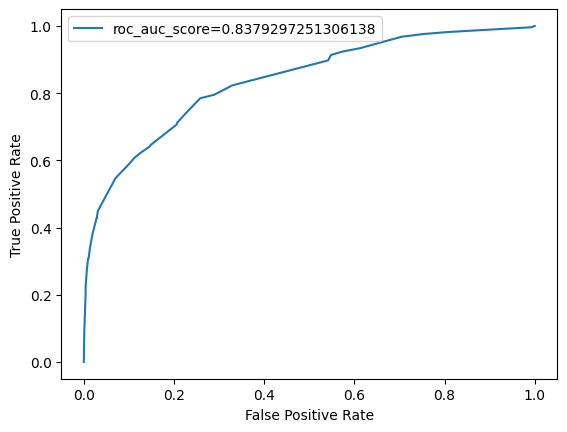

In [23]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Наибольше значение метрики *f1* достигается при глубине дерева равной 6.

**Случайный лес**

In [24]:
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 50):
    for depth in range(1, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1337)
        model.fit(features_train, target_train)
        f1 = f1_score(target_valid, model.predict(features_valid))
        best_depth, best_est, best_f1 = (depth, est, f1) if f1 > best_f1 else (best_depth, best_est, best_f1)

print('best depth =', best_depth, '\nbest estimators=', best_est, '\nbest f1 =', best_f1)

best depth = 22 
best estimators= 37 
best f1 = 0.6133333333333334


In [25]:
model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_est, random_state=1337)
model.fit(features_train, target_train)

RandomForestClassifier(max_depth=22, n_estimators=37, random_state=1337)

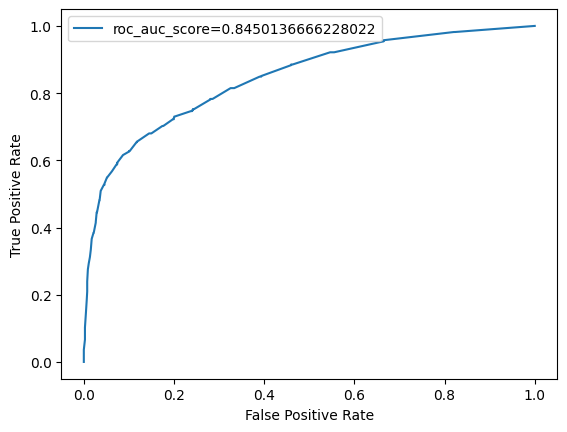

In [26]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Наилучшее значение метрики *f1* достигается при глубине дерева равной 22 и при количестве деревьев равному 37. Значение самой метрики *f1* стало больше, относительно модели **Дерева решений**, значение метрики *AUC-ROC* тоже изменилось в лучшую сторону. *F1* увеличилось почти на *0.04*, а *AUC-ROC* на *0.008*.

**Логистическая регрессия**

In [27]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
penaltys = ['l1', 'l2', 'none']
best_solver = ''
best_penalty = ''
best_f1 = 0

for solv in solvers:
    for pen in penaltys:
        try: 
            model = LogisticRegression(solver=solv, max_iter=1000, penalty=pen, random_state=1337)
            model.fit(features_train, target_train)
            f1 = f1_score(target_valid, model.predict(features_valid))
            best_f1, best_solver, best_penalty = (f1, solv, pen) if f1 > best_f1 else (best_f1, best_solver, best_penalty)
        except: 
            continue

print('best solver =', best_solver, '\nbest penalty =', best_penalty, '\nbest f1 =', best_f1)

best solver = liblinear 
best penalty = l1 
best f1 = 0.33381712626995647


In [28]:
model = LogisticRegression(solver=best_solver, penalty=best_penalty, max_iter=1000, random_state=1337)
model.fit(features_train, target_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=1337,
                   solver='liblinear')

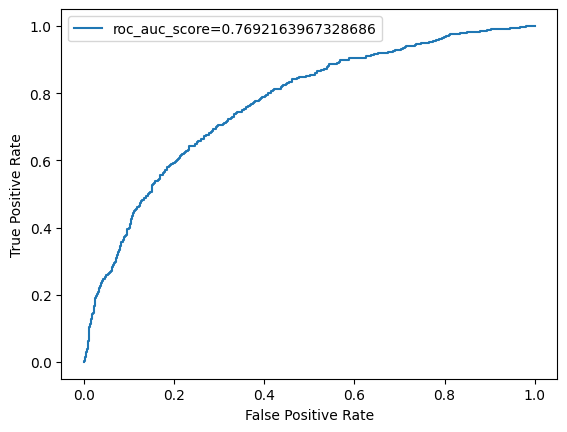

In [29]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Наилучшее значение *f1* достигается при следующих гиперпараметрах: `solver='liblinear'`, `penalty='l1'`. Однако, значение *f1* метрики слишком мало, особенно по сравнению с другими моделями. Значение *AUC-ROC* тоже меньше относительно предыдущих моеделей.

**Выводы:**
- *Дерево решений*: f1 = 0.570, AUC-ROC = 0.838;
- *Случайный лес*: f1 = 0.613, AUC-ROC = 0.845;
- *Логистическая регрессия*: f1 = 0.334, AUC-ROC = 0.769;
- Лучший результат у *Случайного леса*

Постараемся улучшить полученные результаты.

## Борьба с дисбалансом

Как мы уже выяснили, объектов отрицательного класса почти в 4 раза больше, чем объектов положительного класса. Изучим разные методы борьбы с дисбалансом классов и выберем оптимальную модель и оптимальный метод корректировки дисбаланса классов.

<AxesSubplot:ylabel='Exited'>

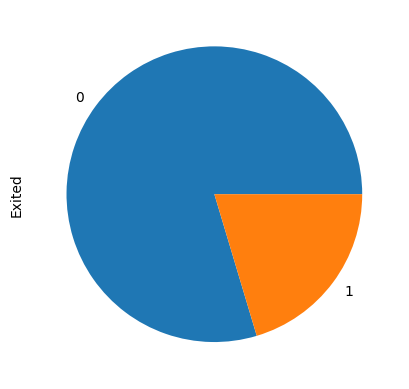

In [30]:
data.groupby('Exited')['Exited'].count().plot.pie()

### Увеличение выборки для борьбы с дисбалансом (upsampling)

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    return shuffle(pd.concat([features_zeros] + [features_ones] * repeat),
                   pd.concat([target_zeros] + [target_ones] * repeat), 
                   random_state=1337)

In [32]:
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

0.9675324675324676


<AxesSubplot:ylabel='Exited'>

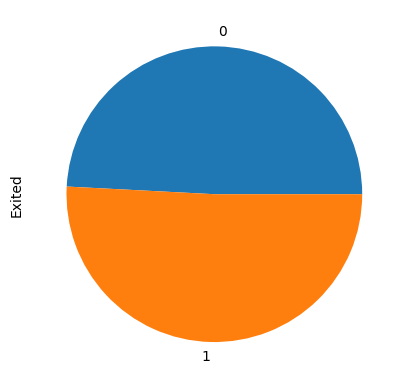

In [33]:
print((target_upsampled_train == 0).sum()  / (target_upsampled_train == 1).sum())
target_upsampled_train.groupby(target_upsampled_train).count().plot.pie()

На графиках наглядно видно, что соотношение классов приблизилось к 1 (точнее, 0.97). Посмотрим, как изменился результат после балансировки.

**Дерево решений**

In [34]:
best_depth = 0
best_f1 = 0

for depth in range(1, 50):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1337)
    model.fit(features_upsampled_train, target_upsampled_train)
    f1 = f1_score(target_valid, model.predict(features_valid))
    best_depth, best_f1 = (depth, f1) if f1 > best_f1 else (best_depth, best_f1)

print('best depth =', best_depth, '\nbest f1 =', best_f1)

best depth = 6 
best f1 = 0.5758928571428572


In [35]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=1337)
model.fit(features_upsampled_train, target_upsampled_train)

DecisionTreeClassifier(max_depth=6, random_state=1337)

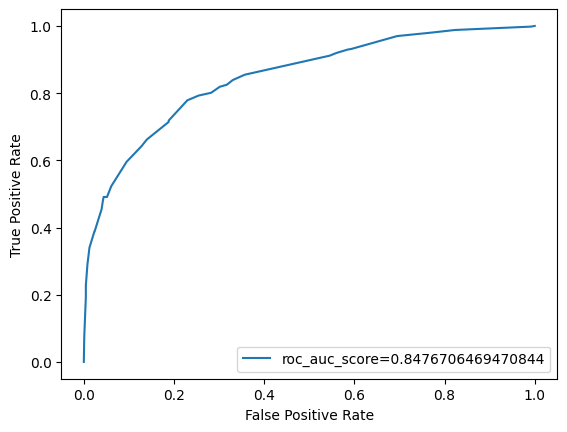

In [36]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение метрики *f1* увеличилось на 0.006. Значение метрики *AUC-ROC* увеличилось на 0.010.

**Случайный лес**

In [37]:
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 50):
    for depth in range(1, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1337)
        model.fit(features_upsampled_train, target_upsampled_train)
        f1 = f1_score(target_valid, model.predict(features_valid))
        best_depth, best_est, best_f1 = (depth, est, f1) if f1 > best_f1 else (best_depth, best_est, best_f1)

print('best depth =', best_depth, '\nbest estimators=', best_est, '\nbest f1 =', best_f1)

best depth = 15 
best estimators= 38 
best f1 = 0.6392600205549847


In [38]:
model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_est, random_state=1337)
model.fit(features_upsampled_train, target_upsampled_train)

RandomForestClassifier(max_depth=15, n_estimators=38, random_state=1337)

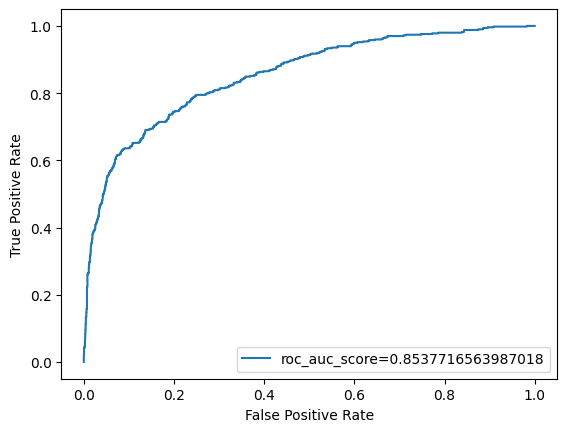

In [39]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение метрики *f1* увеличилось на 0.026. Значение метрики *AUC-ROC* увеличилось на 0.009.

**Логистическая регрессия**

In [40]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
penaltys = ['l1', 'l2', 'none']
best_solver = ''
best_penalty = ''
best_f1 = 0

for solv in solvers:
    for pen in penaltys:
        try: 
            model = LogisticRegression(solver=solv, max_iter=1000, penalty=pen, random_state=1337)
            model.fit(features_upsampled_train, target_upsampled_train)
            f1 = f1_score(target_valid, model.predict(features_valid))
            best_f1, best_solver, best_penalty = (f1, solv, pen) if f1 > best_f1 else (best_f1, best_solver, best_penalty)
        except: 
            continue

print('best solver =', best_solver, '\nbest penalty =', best_penalty, '\nbest f1 =', best_f1)

best solver = liblinear 
best penalty = l1 
best f1 = 0.49137336093857836


In [41]:
model = LogisticRegression(solver=best_solver, penalty=best_penalty, max_iter=1000, random_state=1337)
model.fit(features_upsampled_train, target_upsampled_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=1337,
                   solver='liblinear')

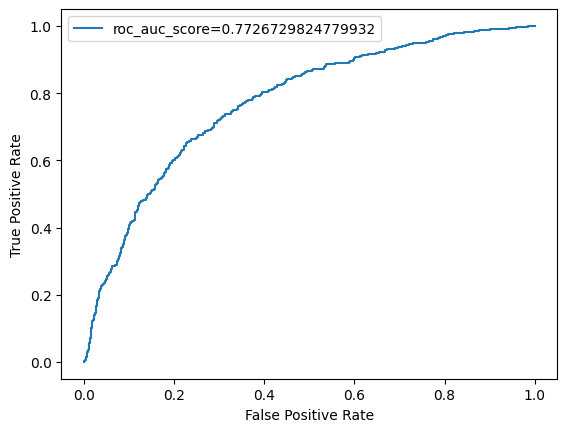

In [42]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение метрики *f1* увеличилось на 0.158. Значение метрики *AUC-ROC* увеличилось на 0.003.

**Итоги:**
- у модели *Дерево решений* динамика положительная: *f1* увеличился на 0.006, *AUC-ROC* - на 0.010;
- у модели *Случайный лес* динамика так же положительная: *f1* увеличился на 0.026, *AUC-ROC* - на 0.009;
- у модели *Логистическая регрессия* динамика положительная: *f1* увеличился на 0.158, *AUC-ROC* - на 0.003.

Наблюдаем положительную динамику у всех моделей. Наибольшая разница заметна у модели *Логистической регрессии*.

### Уменьшение выборки для борьбы с дисбалансом (downsampling)

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target  == 1]
    return shuffle(pd.concat([features_zeros.sample(frac=fraction, random_state=1337)] + [features_ones]),
                   pd.concat([target_zeros.sample(frac=fraction, random_state=1337)] + [target_ones]),
                   random_state=1337)

In [44]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.25)

<AxesSubplot:ylabel='Exited'>

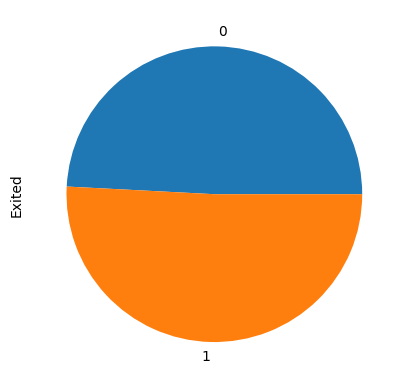

In [45]:
target_downsampled_train.groupby(target_downsampled_train).count().plot.pie()

С дисбалансом разобрались, начинаем тестировать модели.

**Дерево решений**

In [46]:
best_depth = 0
best_f1 = 0

for depth in range(1, 50):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1337)
    model.fit(features_downsampled_train, target_downsampled_train)
    f1 = f1_score(target_valid, model.predict(features_valid))
    best_depth, best_f1 = (depth, f1) if f1 > best_f1 else (best_depth, best_f1)

print('best depth =', best_depth, '\nbest f1 =', best_f1)

best depth = 6 
best f1 = 0.5763993948562783


In [47]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=1337)
model.fit(features_downsampled_train, target_downsampled_train)

DecisionTreeClassifier(max_depth=6, random_state=1337)

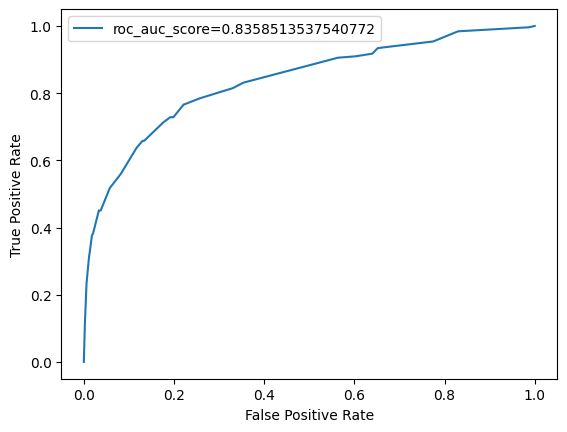

In [48]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* увеличилось на 0.006 относительно исходных данных, *AUC-ROC* уменьшилось на 0.002.

**Случайный лес**

In [49]:
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 50):
    for depth in range(1, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1337)
        model.fit(features_downsampled_train, target_downsampled_train)
        f1 = f1_score(target_valid, model.predict(features_valid))
        best_depth, best_est, best_f1 = (depth, est, f1) if f1 > best_f1 else (best_depth, best_est, best_f1)

print('best depth =', best_depth, '\nbest estimators=', best_est, '\nbest f1 =', best_f1)

best depth = 9 
best estimators= 42 
best f1 = 0.5950155763239876


In [50]:
model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_est, random_state=1337)
model.fit(features_downsampled_train, target_downsampled_train)

RandomForestClassifier(max_depth=9, n_estimators=42, random_state=1337)

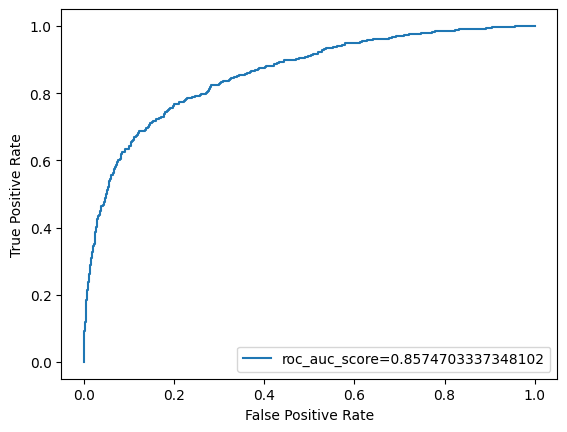

In [51]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* уменьшилось на 0.018 относительно исходных данных, *AUC-ROC* увеличилось на 0.001.

**Логистическая регрессия**

In [52]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
penaltys = ['l1', 'l2', 'none']
best_solver = ''
best_penalty = ''
best_f1 = 0

for solv in solvers:
    for pen in penaltys:
        try: 
            model = LogisticRegression(solver=solv, max_iter=1000, penalty=pen, random_state=1337)
            model.fit(features_downsampled_train, target_downsampled_train)
            f1 = f1_score(target_valid, model.predict(features_valid))
            best_f1, best_solver, best_penalty = (f1, solv, pen) if f1 > best_f1 else (best_f1, best_solver, best_penalty)
        except: 
            continue

print('best solver =', best_solver, '\nbest penalty =', best_penalty, '\nbest f1 =', best_f1)

best solver = liblinear 
best penalty = l1 
best f1 = 0.4924137931034483


In [53]:
model = LogisticRegression(solver=best_solver, penalty=best_penalty, max_iter=1000, random_state=1337)
model.fit(features_downsampled_train, target_downsampled_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=1337,
                   solver='liblinear')

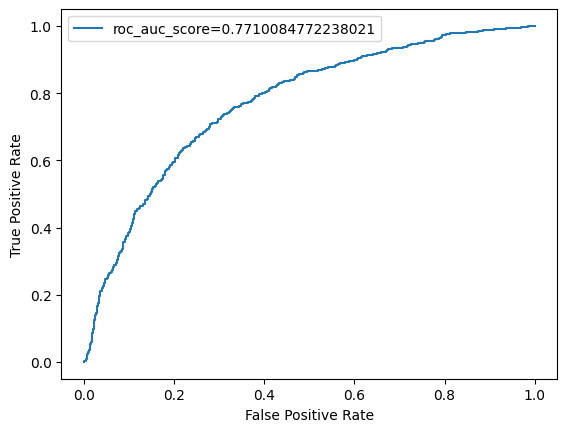

In [54]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* увеличилось на 0.159 относительно исходных данных, *AUC-ROC* - на 0.002.

**Итоги:**
- у модели *Дерево решений* динамика следующая: *f1* увеличился на 0.006, *AUC-ROC* уменьшилось на 0.002;
- у модели *Случайный лес* динамика следующая: *f1* уменьшилось на 0.018, *AUC-ROC* увеличилось на 0.001;
- у модели *Логистическая регрессия* динамика положительная: *f1* увеличился на 0.159, *AUC-ROC* - на 0.002.

Наблюдаем положительную динамику не у всех моделей. Наибольшая разница заметна у модели *Логистической регрессии*. Нельзя однозначно сказать, какой из уже использованных подходов оказался лучше. Динамика в одних случаях на стороне *upsampling*, в других - у *downsampling*. Однако, с *upsamling* мы не наблюдали ухудшения метрик.

### Использование гиперпараметра `class_weight` для борьбы с дисбалансом

**Дерево решений**

In [55]:
best_depth = 0
best_f1 = 0

for depth in range(1, 50):
    model = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=1337)
    model.fit(features_train, target_train)
    f1 = f1_score(target_valid, model.predict(features_valid))
    best_depth, best_f1 = (depth, f1) if f1 > best_f1 else (best_depth, best_f1)

print('best depth =', best_depth, '\nbest f1 =', best_f1)

best depth = 6 
best f1 = 0.5776061776061776


In [56]:
model = DecisionTreeClassifier(max_depth=best_depth, class_weight='balanced', random_state=1337)
model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=1337)

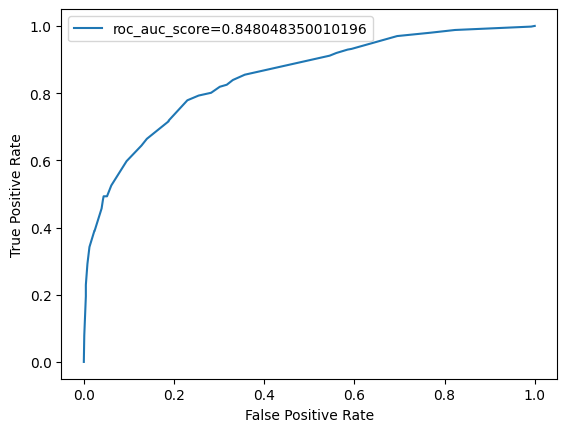

In [57]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* увеличилось на 0.007 относительно исходных данных, *AUC-ROC* - на 0.010.

**Случайный лес**

In [58]:
best_depth = 0
best_est = 0
best_f1 = 0

for est in range(1, 50):
    for depth in range(1, 50):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, class_weight='balanced', random_state=1337)
        model.fit(features_train, target_train)
        f1 = f1_score(target_valid, model.predict(features_valid))
        best_depth, best_est, best_f1 = (depth, est, f1) if f1 > best_f1 else (best_depth, best_est, best_f1)

print('best depth =', best_depth, '\nbest estimators=', best_est, '\nbest f1 =', best_f1)

best depth = 8 
best estimators= 47 
best f1 = 0.6237712243074174


In [59]:
model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_est, class_weight='balanced', random_state=1337)
model.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=47,
                       random_state=1337)

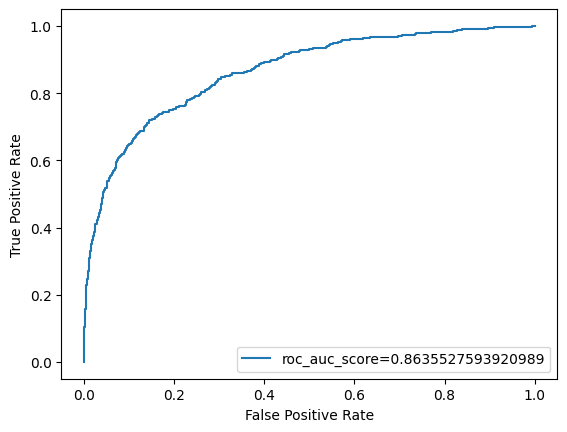

In [60]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* увеличилось на 0.010 относительно исходных данных, *AUC-ROC* - на 0.019.

**Логистическая регрессия**

In [61]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
penaltys = ['l1', 'l2', 'none']
best_solver = ''
best_penalty = ''
best_f1 = 0

for solv in solvers:
    for pen in penaltys:
        try: 
            model = LogisticRegression(solver=solv, max_iter=1000, penalty=pen, class_weight='balanced', random_state=1337)
            model.fit(features_train, target_train)
            f1 = f1_score(target_valid, model.predict(features_valid))
            best_f1, best_solver, best_penalty = (f1, solv, pen) if f1 > best_f1 else (best_f1, best_solver, best_penalty)
        except: 
            continue

print('best solver =', best_solver, '\nbest penalty =', best_penalty, '\nbest f1 =', best_f1)

best solver = lbfgs 
best penalty = none 
best f1 = 0.4922861150070126


In [62]:
model = LogisticRegression(solver=best_solver, penalty=best_penalty, max_iter=1000, class_weight='balanced', random_state=1337)
model.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='none',
                   random_state=1337)

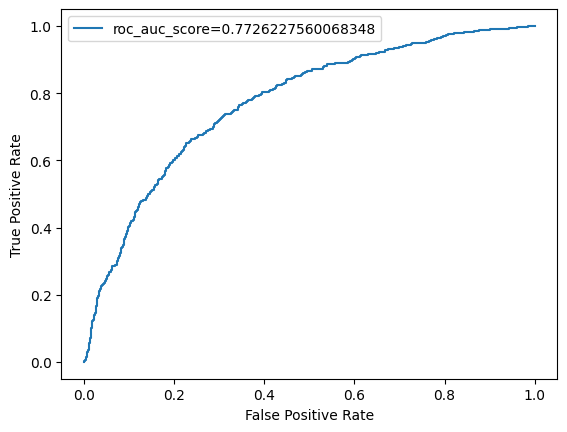

In [63]:
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
plt.plot(fpr, tpr, label='roc_auc_score='+str(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

Значение *f1* увеличилось на 0.158 относительно исходных данных, *AUC-ROC* - на 0.003.

**Итоги:**
- у модели *Дерево решений* динамика положительная: *f1* увеличился на 0.007, *AUC-ROC* - на 0.010;
- у модели *Случайный лес* динамика так же положительная: *f1* увеличился на 0.010, *AUC-ROC* - на 0.019;
- у модели *Логистическая регрессия* динамика положительная: *f1* увеличился на 0.158, *AUC-ROC* - на 0.003.

Наблюдаем положительную динамику у всех моделей. Наибольшая разница заметна у модели *Логистической регрессии*.

<table>
    <thead>
        <th>Модель</th>
        <th>Способ борьбы с дисбалансом</th>
        <th>Метрика</th>
        <th>Было</th>
        <th>Стало</th>
        <th>Динамика</th>
    </thead>
    <tbody>
        <tr>
            <td rowspan=6 align="center"><b>Дерево решений</b></td>
            <td rowspan=2 aling="center"><b>Upsamling</b></td>
            <td aling="center">f1</td>
            <td aling="center">0.570332</td>            
            <td aling="center">0.575893</td>
            <td aling="center">+ 0.005561</td>
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.837930</td>            
            <td aling="center">0.847671</td>
            <td aling="center">+ 0.009741</td>            
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Downsamling</b></td>  
            <td aling="center">f1</td>
            <td aling="center">0.570332</td>            
            <td aling="center">0.576399</td>
            <td aling="center">+ 0.006067</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.837930</td>            
            <td aling="center">0.835851</td>
            <td aling="center">- 0.002079</td>
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Class_weight</b></td>  
            <td aling="center">f1</td>
            <td aling="center">0.570332</td>            
            <td aling="center">0.577606</td>
            <td aling="center">+ 0.007274</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.837930</td>            
            <td aling="center">0.848048</td>
            <td aling="center">+ 0.010118</td>
        </tr>
        <tr>
            <td rowspan=6 align="center"><b>Случайный лес</b></td>
            <td rowspan=2 aling="center"><b>Upsamling</b></td>
            <td aling="center">f1</td>
            <td aling="center">0.613333</td>            
            <td aling="center">0.639260</td>
            <td aling="center">+ 0.025927</td>
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.845014</td>            
            <td aling="center">0.853772</td>
            <td aling="center">+ 0.008758</td>            
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Downsamling</b></td>  
            <td aling="center">f1</td>            
            <td aling="center">0.613333</td>
            <td aling="center">0.595016</td>
            <td aling="center">- 0.018317</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.845014</td>            
            <td aling="center">0.857470</td>
            <td aling="center">+ 0.012456</td>
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Class_weight</b></td>  
            <td aling="center">f1</td>
            <td aling="center">0.613333</td>            
            <td aling="center">0.623771</td>
            <td aling="center">+ 0.010438</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.845014</td>            
            <td aling="center">0.863553</td>
            <td aling="center">+ 0.018539</td>
        </tr>
        <tr>
            <td rowspan=6 align="center"><b>Логистическая регрессия</b></td>
            <td rowspan=2 aling="center"><b>Upsamling</b></td>
            <td aling="center">f1</td>
            <td aling="center">0.333817</td>            
            <td aling="center">0.491373</td>
            <td aling="center">+ 0.157556</td>
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.769216</td>            
            <td aling="center">0.772673</td>
            <td aling="center">+ 0.003457</td>            
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Downsamling</b></td>  
            <td aling="center">f1</td>
            <td aling="center">0.333817</td>            
            <td aling="center">0.492414</td>
            <td aling="center">+ 0.158597</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.769216</td>            
            <td aling="center">0.771008</td>
            <td aling="center">+ 0.001792</td>
        </tr>
        <tr>
            <td rowspan=2 aling="center"><b>Class_weight</b></td>  
            <td aling="center">f1</td>
            <td aling="center">0.333817</td>            
            <td aling="center">0.492286</td>
            <td aling="center">+ 0.158469</td>            
        </tr>
        <tr>
            <td aling="center">auc-roc</td>
            <td aling="center">0.769216</td>            
            <td aling="center">0.772623</td>
            <td aling="center">+ 0.003407</td>
        </tr>
    </tbody>
</table>

Исходя из итоговой таблицы по *f1* метрике лучше всего себя показала модель **Случайный лес**, как и по метрике *AUC-ROC*. Наилучший прирост был у модели **Логистической регрессии**, но значения всё равно сильно меньше, по сравнению с остальными моделями. Итоговая модель - **Случайный лес**. Наилучший способ борьбы с дисбалансом для итоговой модели оказался **Upsamling**, его и оставим для конечного тестирования. 

## Тестирование модели

Повторим результаты лучшей модели и лучшего способа борьбы с дисбалансом.

In [64]:
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

In [67]:
model = RandomForestClassifier(max_depth=15, n_estimators=38, random_state=1337)
model.fit(features_upsampled_train, target_upsampled_train)
print('f1-score =', f1_score(target_valid, model.predict(features_valid)),
      '\nAUC-ROC =', roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]))

f1-score = 0.6392600205549847 
AUC-ROC = 0.8537716563987018


**Вывод**
После борьбы с дисбалансом классов наилучшей моделью для нашей задачи оказалась модель **Случайного леса** с гиперпараметрами `max_depth=15`, `n_esimators=38`. При такой модели метрика *f1* приблизительно равняется 0.639, метрика *AUC-ROC* приблизительно равняется 0.854, что является наилучшим результатом среди всех рассмотренных моделей. 

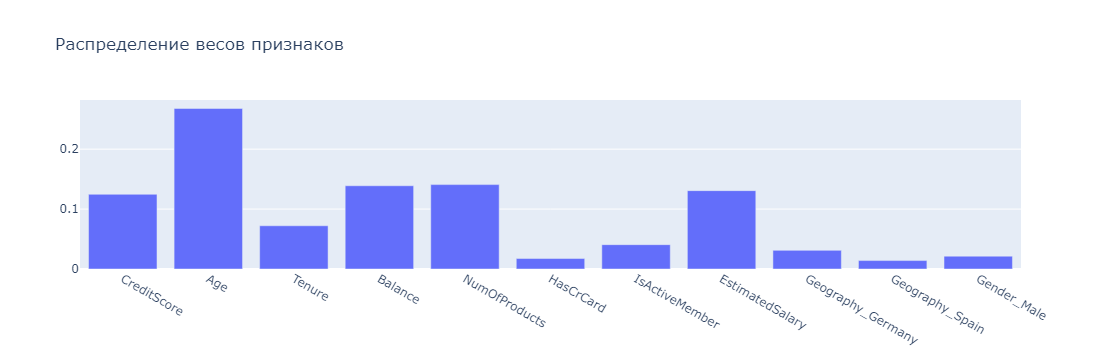

In [68]:
fig = dict({
    "data" : [{"type": "bar",
               "x": features_upsampled_train.columns,
               "y": model.feature_importances_}],
    "layout": {"title": {"text": "Распределение весов признаков"}}
})
pio.show(fig)

В модели сильно выделяется **Возраст**, как основной фактор. Так же достаточно существенно влияют сумма на счету, количество продуктов и зарплата.